In [ ]:
import os
import warnings

warnings.filterwarnings("ignore")

In [ ]:
import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping
import pandas as pd
import torch

from pytorch_forecasting import Baseline, NBeats, TimeSeriesDataSet
from pytorch_forecasting.data import NaNLabelEncoder
from pytorch_forecasting.data.examples import generate_ar_data
from pytorch_forecasting.metrics import SMAPE
import numpy as np
import shutil
import matplotlib.pyplot as plt

In [ ]:
#ハイパーパラメータ
#データセットを分割する個数
counts = 3

max_encoder_length = 300
max_prediction_length =100


# 乱数シードを設定
seed_value = 42
np.random.seed(seed_value)
torch.manual_seed(seed_value)
torch.backends.cudnn.deterministic = True  # GPU使用時に再現性を高めるための設定
torch.backends.cudnn.benchmark = False  # GPU使用時に再現性を高めるための設定

In [ ]:
# ディレクトリが存在する場合は削除する
def delete_dir(dir_path):
    if os.path.exists(dir_path):
        try:
            shutil.rmtree(dir_path)  # ディレクトリを削除
            print(f"ディレクトリ '{dir_path}' を削除しました。")
        except OSError as e:
            print(f"ディレクトリを削除する際にエラーが発生しました: {e}")
    else:
        print(f"ディレクトリ '{dir_path}' は存在しません。")

# 新たにディレクトリを作成
def make_dir(dir_path):
    try:
        os.mkdir(dir_path)  # ディレクトリを作成
        print(f"新たにディレクトリ '{dir_path}' を作成しました。")
    except OSError as e:
        print(f"ディレクトリを作成する際にエラーが発生しました: {e}")


In [ ]:
# 削除・作成するディレクトリのパスを指定してください
dir_path = "./lightning_logs"
delete_dir(dir_path)
# make_dir(dir_path)

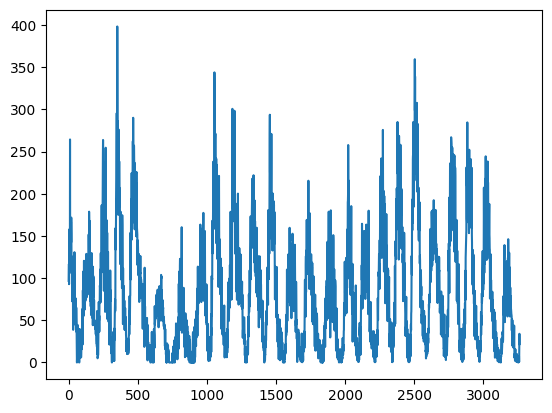

In [18]:
df = pd.read_csv('./Sunspots.csv')
df = df[:int(df.shape[0]/counts)*counts]
plt.plot(df['Monthly Mean Total Sunspot Number'].values)

,Unnamed: 0,Date,Monthly Mean Total Sunspot Number
0,0,1749-01-31,96.700
1,1,1749-02-28,100.500
2,2,1749-03-31,105.900
3,3,1749-04-30,102.625
4,4,1749-05-31,110.440


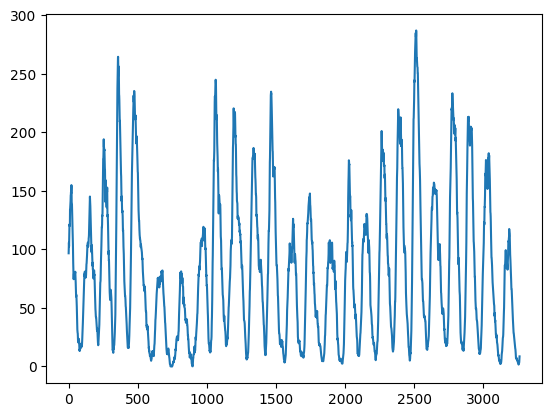

In [19]:
# ウィンドウサイズを設定
window_size = 12

# 移動平均を計算
df['Monthly Mean Total Sunspot Number'] = df['Monthly Mean Total Sunspot Number'].rolling(window=window_size, min_periods=1).mean()


plt.plot(df['Monthly Mean Total Sunspot Number'].values)
df.head()


In [20]:
new_column_names = {'Unnamed: 0': 'time_idx', 'Date': 'date', 'Monthly Mean Total Sunspot Number': 'value'}
df.rename(columns=new_column_names, inplace=True)
df['series'] = 0
j=1

for j in range(counts):
    df['series'][int(j*df.shape[0]/counts):int((j+1)*df.shape[0]/counts)] = j

for i in range(counts):
    for j in range(int(df.shape[0]/counts)):
        df.loc[j+int(i*df.shape[0]/counts), 'time_idx'] = j

df['value'] = (df['value'] - df['value'].min()) / (df['value'].max() - df['value'].min())
df

,time_idx,date,value,series
0,0,1749-01-31,0.336885,0
1,1,1749-02-28,0.350123,0
2,2,1749-03-31,0.368936,0
3,3,1749-04-30,0.357526,0
4,4,1749-05-31,0.384753,0
...,...,...,...,...
3259,1083,2020-08-31,0.010510,2
3260,1084,2020-09-30,0.010364,2
3261,1085,2020-10-31,0.014429,2
3262,1086,2020-11-30,0.024154,2


In [ ]:
# create dataset and dataloaders


training_cutoff = df["time_idx"].max() - max_prediction_length

context_length = max_encoder_length
prediction_length = max_prediction_length

training = TimeSeriesDataSet(
    df[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="value",
    categorical_encoders={"series": NaNLabelEncoder().fit(df.series)},
    group_ids=["series"],
    # only unknown variable is "value" - and N-Beats can also not take any additional variables
    time_varying_unknown_reals=["value"],
    max_encoder_length=context_length,
    max_prediction_length=prediction_length,
)

validation = TimeSeriesDataSet.from_dataset(training, df, min_prediction_idx=training_cutoff + 1)
batch_size = 400
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=0)


In [ ]:
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
# from pytorch_lightning.loggers import TensorBoardLogger
# logger = TensorBoardLogger("/Users/kishimoto/app/nb/logs", name="lightning_logs")
trainer = pl.Trainer(
    max_epochs=500,
    accelerator="cpu",
    enable_model_summary=True,
    gradient_clip_val=0.01,
    callbacks=[early_stop_callback],
    limit_train_batches=150,
    default_root_dir='./'
    # logger=logger
)


net = NBeats.from_dataset(
    training,
    learning_rate=1e-3,
    log_interval=10,
    log_val_interval=1,
    weight_decay=1e-2,
    widths=[32, 512],
    backcast_loss_ratio=1.0,
)

# find optimal learning rate
from lightning.pytorch.tuner import Tuner

res = Tuner(trainer).lr_find(net, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader, min_lr=1e-5)
print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()
net.hparams.learning_rate = res.suggestion()

In [ ]:
trainer.fit(
    net,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

In [ ]:
best_model_path = trainer.checkpoint_callback.best_model_path
print(best_model_path)
best_model = NBeats.load_from_checkpoint(best_model_path)

In [21]:
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = best_model.predict(val_dataloader)

(actuals - predictions).abs().mean()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


tensor(0.1338)

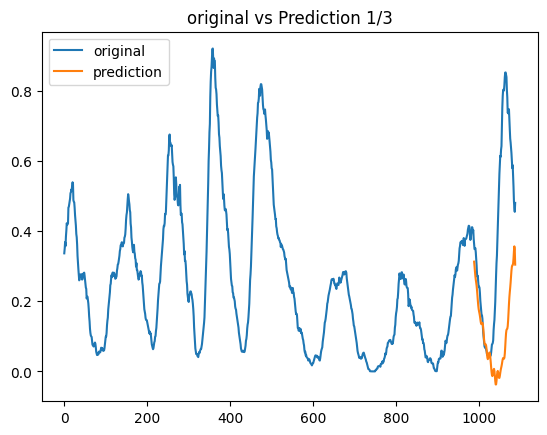

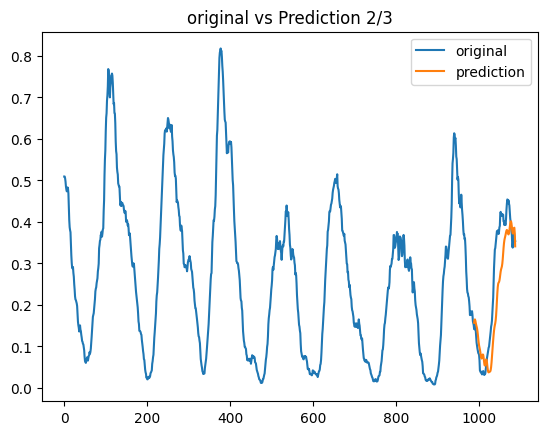

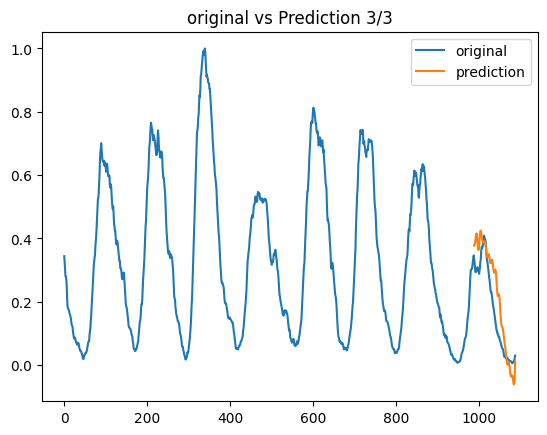

In [22]:
#元のデータセットをcountsで分割しているので、それぞれのデータセットに対して予測を行う
x = np.linspace(0, df["time_idx"].max(), num=df["time_idx"].max()+1)
for i in range(counts):
  original = df[df['series']==i]['value'].values

  plt.plot(original)
  plt.plot(x[training_cutoff+1:],predictions[i])
  plt.legend(['original', 'prediction'])
  plt.title(f'original vs Prediction {i+1}/{counts}')
  plt.show()
  

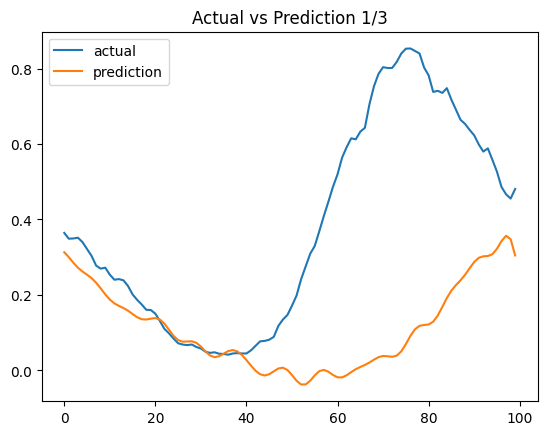

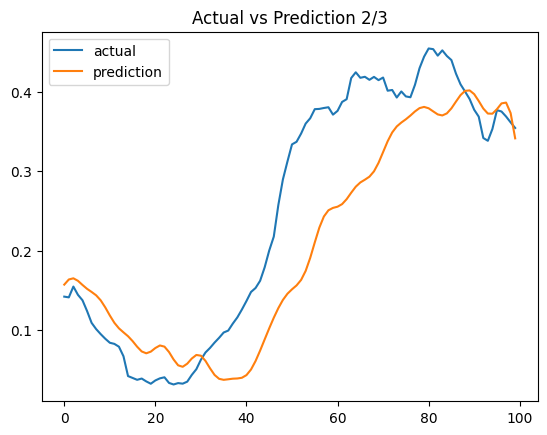

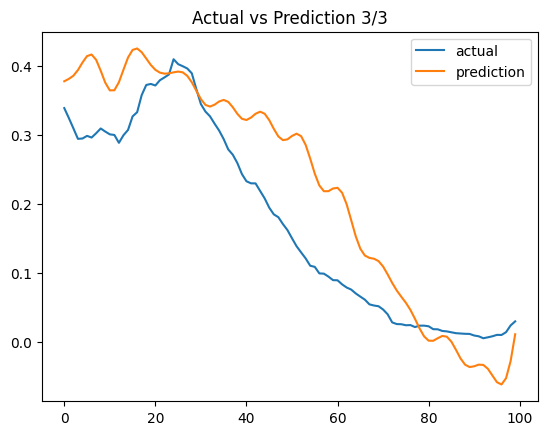

In [23]:
for i in range(counts):
  plt.plot(actuals[i])
  plt.plot(predictions[i])
  plt.legend(['actual', 'prediction'])
  plt.title(f'Actual vs Prediction {i+1}/{counts}')
  plt.show()
    
